In [2]:
import pandas as pd
import hydrofunctions as hf
import matplotlib.pyplot as plt
from slacker import Slacker
%matplotlib inline

In [3]:
#Slack API token
slack = Slacker('xxxxx')

In [12]:
SAC_ID = '373507121472101' #SAC near Indian Creek USGS Station ID
start = '2019-05-01'
end = '2019-06-01'

#Get response object
response = hf.get_nwis(SAC_ID,'iv', start, end)
responseDV = hf.get_nwis(SAC_ID,'dv', start, end)

#Check Respone
print('IV:\n',response.ok)
print(response.status_code)

print('\nDV:\n',responseDV.ok)
print(responseDV.status_code)

#Convert to json
data_json = response.json()
data_jsonDV = responseDV.json()

#convert to pandas dataframe, rename columns, turn time index into normal column
data = hf.extract_nwis_df(data_json)
data.columns = ['i_flow','qualifiers']
data.reset_index(level=0, inplace=True)
data['datetime'] = pd.to_datetime(data['datetime'])
data['datetime']=data['datetime'].dt.tz_localize(None)

dataDV = hf.extract_nwis_df(data_jsonDV)
dataDV.columns = ['dv_flow','qualifiers']

IV:
 True
200

DV:
 True
200


In [21]:
AH_ID = '11173200' #Arroyo Hondo USGS station ID
start = '2019-05-01'
end = '2019-06-01'

#Get response object
AHresponseIV = hf.get_nwis(AH_ID,'iv', start, end)
AHresponseDV = hf.get_nwis(AH_ID,'dv', start, end)

#Check Respone
print('IV:\n',AHresponseIV.ok)
print(AHresponseIV.status_code)

print('\nDV:\n',AHresponseDV.ok)
print(AHresponseDV.status_code)

#Convert to json
AH_jsonIV = AHresponseIV.json()
AH_jsonDV = AHresponseDV.json()

#convert to pandas dataframe, rename columns, turn time index into normal column
AH_IV = hf.extract_nwis_df(AH_jsonIV)
AH_IV.columns = ['iv_flow','qualifiers']
AH_IV.reset_index(level=0, inplace=True)
AH_IV['datetime'] = pd.to_datetime(AH_IV['datetime'])
AH_IV['datetime']=AH_IV['datetime'].dt.tz_localize(None)

AH_DV = hf.extract_nwis_df(AH_jsonDV)
AH_DV.columns = ['dv_flow','qualifiers']

AH_IV

IV:
 True
200

DV:
 True
200


,datetime,iv_flow,qualifiers
0,2019-05-01 00:00:00,20.5,P
1,2019-05-01 00:15:00,20.5,P
2,2019-05-01 00:30:00,20.5,P
3,2019-05-01 00:45:00,20.5,P
4,2019-05-01 01:00:00,20.5,P
...,...,...,...
3067,2019-06-01 22:45:00,17.8,P
3068,2019-06-01 23:00:00,18.3,P
3069,2019-06-01 23:15:00,17.8,P
3070,2019-06-01 23:30:00,18.3,P


In [17]:
## SAC ALARM

threshold = 3 #alarm threshold, cfs

##Find when exceeded threshold
#Find if going above or below threshold while moving forward in time
data['changed'] = (data['i_flow'] > threshold).astype(int).diff().fillna(1).astype(int)
data.loc[0,'changed'] = 0 #Set first entry to no change

TI = pd.DataFrame({
     'Begin': data.loc[data.changed ==  1,'datetime'].reset_index(drop=True), 
     'End': data.loc[data.changed ==  -1,'datetime'].reset_index(drop=True)})

#Find duration
TI['Duration'] = TI.End - TI.Begin

#Calculate max flow during exceeded window
def maxflow(x):
    return data.loc[(data.datetime >= (x.Begin)) & (data.datetime <= (x.End)) ,'i_flow'].max()

TI['Max_Flow'] = TI.apply(maxflow, axis=1)

Exceeded  3 CFS during these intervals:


,Begin,End,Duration,Max_Flow
0,2019-05-19 09:45:00,2019-05-20 08:45:00,23:00:00,4.33
1,2019-05-22 03:45:00,2019-05-22 13:45:00,10:00:00,3.40


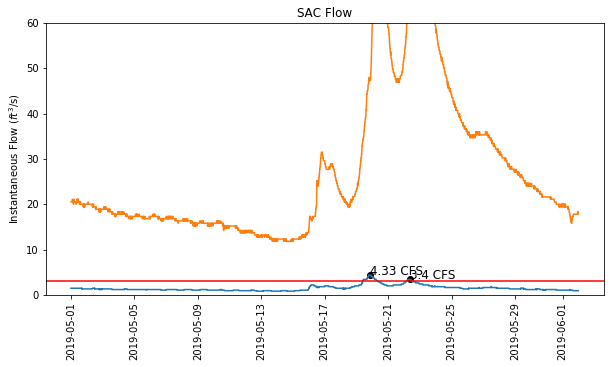

In [25]:
#Plot figure


#Plot figure
plt.figure(figsize=(10,5))
plt.plot(data.datetime, data.i_flow)
plt.plot(AH_IV.datetime, AH_IV.iv_flow)
plt.title('SAC Flow')
plt.ylabel('Instantaneous Flow ($ft^3$/s)')
plt.xticks(rotation='vertical')
plt.ylim((0, 60)) 
plt.axhline(threshold, color='r')
#Add max flow points
xL = TI.Begin + (TI.End - TI.Begin)/2
plt.scatter(xL,TI.Max_Flow, color='black')
for i in range(0,len(xL)):
    x = xL[i]
    y = TI.Max_Flow[i]
    plt.text(x, y+0.1, str(TI.Max_Flow[i])+" CFS", fontsize=12)

plt.savefig('SAC_flow.png', dpi=300)

#print results
print('Exceeded ',threshold,'CFS during these intervals:')
TI

In [27]:
## Post to Slack
#Save figure
r = slack.chat.post_Message(channel='test',
                            text='SAC flow has exceeded 3 CFS!')

    #Post figure to slack
r = slack.files.upload(file_='SAC_flow.png',
                           channels=['test'],
                           title='Current SAC Flow')

AttributeError: 'Chat' object has no attribute 'postMessage'

(0, 5)

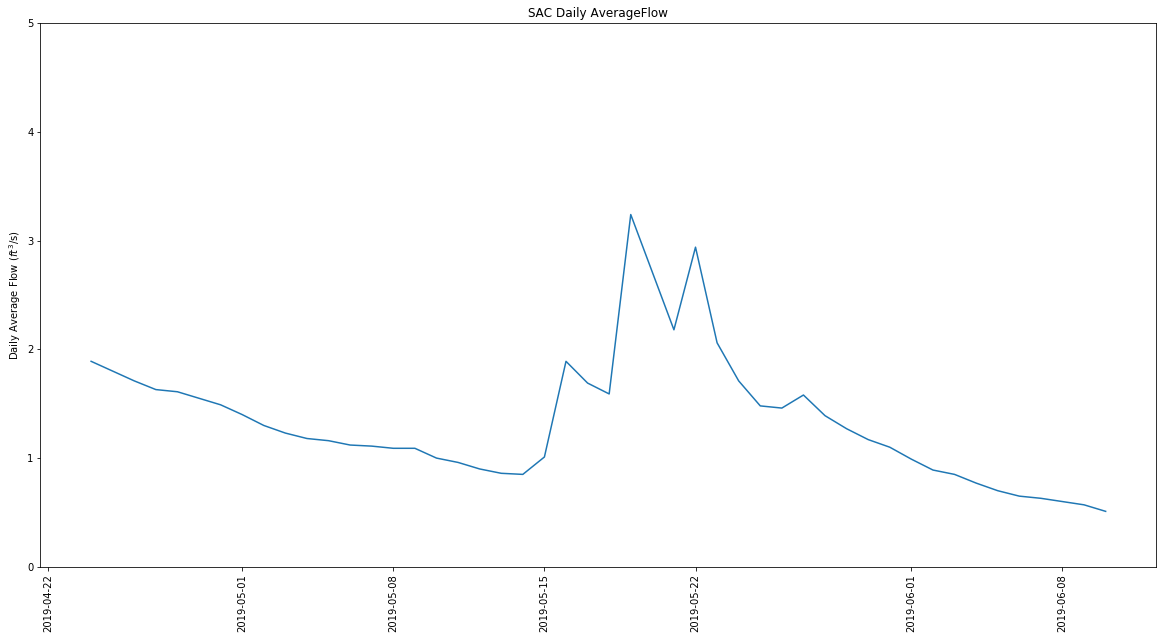

In [181]:
#Plot figure
dataDV.columns = ['dv_flow','qualifiers']

plt.figure(figsize=(20,10))
plt.plot(dataDV.dv_flow)
plt.title('SAC Daily AverageFlow')
plt.ylabel('Daily Average Flow ($ft^3$/s)')
plt.xticks(rotation='vertical')
plt.ylim((0, 5)) 